Introduction to GPU Programming Summer School
========================

D. Quigley, University of Warwick

---

# Tutorial 1: GPU Libraries

The computationally intensive part of many scientific codes reduces to standard numerical operations, e.g. manipulation of large matrices/vectors, performing Fourier transforms, dealing with sparse linear algebra etc.

In the traditional High Performance Computing (HPC) realm of compiled C/C++/Fortran code, there exists a suite of standard optimised libraries for such things. The CUDA toolkit provides GPU-enabled versions of these, and numba provides Python interfaces to these through the pyculib package which we'll experiment with below.

The advantage of this approach is that no real knowledge of GPU programming is required, we simply replace calls to standard CPU functions with GPU-accelerated equivalents. The disadvantage is that we only accelerate part of the code, and may suffer performance overheads associated with transering data between host and device every time we use one of the functions. We'll explore this penalty below.

---


## cuBLAS

BLAS is the suite of [Basic Linear Algebra Subprograms](http://www.netlib.org/blas/). These come in three levels, for both real and complex data types. 

**Level 1** : Vector-vector operations 

**Level 2** : Matrix-vector operations

**Level 3** : Matrix-matrix operations

On any well-managed HPC system, the local installations of numpy and scipy packages will be built on top of BLAS routines (written in C or Fortran) that have been optimised for the particular hardware in use. Optimised BLAS implementations for CPUs include [OpenBLAS](https://www.openblas.net/), [Atlas](http://math-atlas.sourceforge.net/), [Intel MKL](https://software.intel.com/en-us/mkl) and [AMD ACML](https://developer.amd.com/building-with-acml/).

The CUDA toolkit includes [cuBLAS](https://developer.nvidia.com/cublas), a GPU-accelerated BLAS implementation. Let's compare how this performs in comparison to numpy. If you're interested, the numpy implementation on the SCRTP desktops has been built using OpenBLAS, but optimised only for the most common Intel CPU features to ensure compatibility. CPU performace will not be great.

[Documentation for the pyculib interface to cuBLAS](http://pyculib.readthedocs.io/en/latest/cublas.html)

Let's illustrate this with a simple matrix-matrix multiplication example. The BLAS routine `dgemm` (double precision, general matrix-matrix multiply) performs the following operation.

$$ C = \alpha AB + \beta C $$

where $A$, $B$ and $C$ are matrices and $\alpha$ and $\beta$ are scalars. Other specialised routines are available for matrices with particular structure (e.g. banded, tri-diagonal, symmetric) but we won't worry about that today.

In [44]:
import numba.cuda as cuda
import numpy as np
import pyculib.blas as cublas      # Python interface to cuBLAS, cuFFT, cuSPARSE and cuRAND

# Set size of matrix to work with
size = 3

# Create some square matrices and fill them with random numbers
A = np.random.rand(size,size)
B = np.random.rand(size,size)

# Alpha (we'll leave beta as zero)
alpha = 0.5

# Perform the operation described above using standard numpy
C_np = alpha * np.matmul(A,B) 

In [45]:
# Query what we need to pass into cublas.gemm
help(cublas.gemm)

Help on function gemm in module pyculib.blas:

gemm(transa, transb, alpha, A, B, beta=0, C=None, stream=None)
    Generalized matrix-matrix multiplication:
    
    C <- alpha*transa(A)*transb(B) + beta*C
    
    'beta' and 'C' are optional on input. Return 'C'.



The first two arguments  specify if we want to use the matrices as supplied ('N' - no operation) or their transpose ('T'). We'll ignore streams for now.

In [46]:
# Perform the multiplication using the GPU and store the results
C_cu = cublas.gemm('N', 'N', alpha, A, B)

A lot just happend behind the scenes there. The numpy arrays have been copied from the host RAM into the device memory, the matrix operation has been performed using the CUDA cores on the device, and the result has been copied back into the numpy array C_cu in the host memory. The device arrays have then been deleted.

Let's be proper programmers and check that both computations gave the same result.

In [64]:
comp = abs(C_cu - C_np)
if  (comp > np.finfo(float).eps).any() : 
    print("Results do not match!")
else:
    print("Results match!")

Results match!


The next thing to investigate is whether this cuBLAS function is any faster. Let's try a more substantial matrix and time how long numpy takes to perform the same operation as above.

In [5]:
from timeit import default_timer as timer  # Timer

size = 1000

# Create some square matrices and fill them with random numbers
A = np.random.rand(size,size)
B = np.random.rand(size,size)

# What is the time before we start the operation?
t1 = timer()

# Perform the operation described above using standard numpy
C_np = alpha * np.matmul(A,B) 

# What is the time after we finish the operation in milliseconds?
t2 = timer()

# Print time taken
print("Matrix multiplication using numpy took : ",1000*(t2-t1)," milliseconds.")

Matrix multiplication using numpy took :  89.21825198922306  milliseconds.


To time how long cuBLAS takes to do the same thing we'll use its own timer function.

In [6]:
# First event before we call gemm
t1 = timer()

# Do the multiplication
C_cu = cublas.gemm('N', 'N', alpha, A, B)

# Second event after we call gemm
t2 = timer()

# Print time taken
print("Matrix multiplication using cuBLAS took : ",1000*(t2-t1)," milliseconds.")

Matrix multiplication using cuBLAS took :  33.73379504773766  milliseconds.


When I did this using the K20c in brigitte.csc.warwick.ac.uk the GPU was a factor of three faster for 1000x1000 matrices. We'll explore how this scales with matrix size using the GPUs on Tinis a little later - timings measured inside Jupyter notebooks tend not to be reliable.

Recall that `cublas.gemm` is copying data to and from the GPU as well as performing the calculation. We can seperate this out into smaller steps to understand where the time is being spent.

First, let's explicitly copy the arrays into the device memory. Note the convention that arrays which live in the device memory are given variable names prefixed with `d_`. For reference in this section see [Section 3.3 of the documentation on Numba for CUDA GPUs](https://numba.pydata.org/numba-doc/dev/cuda/memory.html).

In [7]:
t1 = timer()

# Create new device arrays - first copy A and B
d_A = cuda.to_device(A)
d_B = cuda.to_device(B)

# and create a new array on the device to hold C (faster than copying an empty array from the host)
d_C = cuda.device_array((size,size))

t2 = timer()

# Print time taken
print("Creating device arrays took : ",1000*(t2-t1)," milliseconds.")

Creating device arrays took :  13.609922025352716  milliseconds.


The python interface we're using is clever enough to understand that when we pass device arrays as arguments to cuBLAS functions it should use those instead of copying data over from the host.

In [10]:
t1 = timer()

# Do the multiplication
cublas.gemm('N', 'N', alpha, d_A, d_B)

t2 = timer()

# Print time taken
print("Matrix multiplication using cuBLAS took : ",1000*(t2-t1)," milliseconds.")

Matrix multiplication using cuBLAS took :  56.791558978147805  milliseconds.


We might now want to copy the result stored in the device array back onto the host.

In [11]:
t1 = timer()

C_cu = d_C.copy_to_host()

t2 = timer()

# Print time taken
print("Copying output back to host memory took : ",1000*(t2-t1)," milliseconds.")

Copying output back to host memory took :  2.9837669571861625  milliseconds.


Don't read too much into these timings - these can be quite unreliable when running inside Jupyter notebooks. We'll generate some proper timings in the exercises below.

The take home point is that copying data to and from the device takes time. Best performance will be acheived by doing as much work as possible on the arrays while they are on the device, minimising copies between host and device memory.

## cuBLAS exercises

You should now have everything you need to cannibalise the code snippets above and construct some python scripts which you can run outside of this notebook environment on the *Tinis GPU node*. **Please do not run matrices larger than 1000x1000 in this notebook**. On Tinis you should take timings at several matrix sizes as an average over 10 or so runs.

Questions to explore:

* How large a matrix is needed before the multiplication is 10x faster on the GPU compared to numpy code? 
* What is the largest speedup you can obtain?
* How does the speedup from BLAS level 1 and 2 routines compare to BLAS level 3?
* What is the variability in your timings, what gives rise to this?
* (Advanced) Is the numpy code making use of multiple CPU cores on the Tinis node?
* (Advanced) How does the cuBLAS/numpy performance compare to using scipy.linalg.blas.dgemm?
* (Advanced) How does performance change if using single rather than double precision?
* (Very Advanced) How does the shape of the matrix change performance. Why?

Tutors will be available during the session to help you answer these questions.

---

## cuFFT

cuFFT provides GPU-enabled functions to perform the Fast Fourier Transform on 1D, 2D and 3D data. It can be used as a drop-in replacement for (e.g.) numpy.fft routines.

[Documentation for the pyculib interface to cuFFT](http://pyculib.readthedocs.io/en/latest/cufft.html)

To illustrate how it can be used, we'll look at a trivial image processing example. Let's say we need to obscure the identity of a porg (for GDPR reasons) by blurring an image. We can apply a blur filter by convoluting the image with a 2D Gaussian function.

A convolution can be performed with the following steps:

1. Fourier transform the image and the Gaussian.
2. Multiply each element in the Fourier-transformed image by the corresponding element in the Fourier transformed Gaussian.
3. Inverse Fourier transform the result.

i.e. a convolution becomes a multiplication in Fourier space. This is illustrated using numpy functions and the Python Image Library (PIL) below.

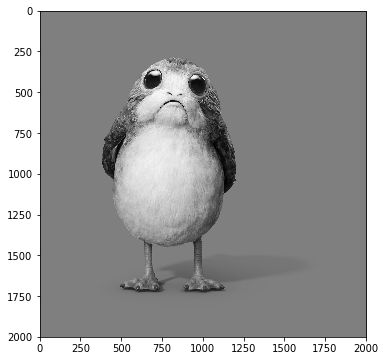

In [30]:
from PIL import Image    # Import the Python Image Library

# We want to use matplot lib to show images inline
import matplotlib.pyplot as plt
%matplotlib inline

# Open an image file and convert to single colour (greyscale)
img = Image.open('porg.jpg').convert('L')

# For now we'll work with a resized version of this image
dim = 2000
img_resized = img.resize((dim,dim))

# ... and convert it into a numpy array of floats
img_data = np.asarray(img_resized,dtype=float)

# Show the porg
plt.figure(figsize = [6, 6])
plt.imshow(img_data,cmap='gray');

Image taken from https://people.com/movies/star-wars-porgs/ (Ed Miller/2017 LucasFilm Ltd).


In [31]:
# We want to convolve this image with a Gaussian, so we need a 2D numpy array 
# representing a Gaussian function with some blurring width
width =  0.2 

# Define a Gaussian in 1D on a grid with the same number of points as the image
domain = np.linspace(-5,5,dim)
gauss = np.exp(-0.5*domain**2/(width*width)) 
    
# Roll this around the 1D boundary so that the Gaussian is centered on grid 0,0
shift = int(dim/2)
gauss = np.roll(gauss,shift)

# Turn into a 2D Gaussian
gauss2D = gauss[:,np.newaxis] * gauss[np.newaxis,:]

First let's do the convolution on the CPU using standard numpy functions so we have something to compare against.

In [32]:
# Create complex arrays to hold the output
# (Doing this here means array creation won't be included in timings below)
img_fft   = np.empty((dim,dim),dtype=complex)
gauss_fft = np.empty((dim,dim),dtype=complex)
img_ifft  = np.empty((dim,dim),dtype=complex)

# Fourier transform the image and the Gaussian using standard numpy functions
t1 = timer()

img_fft   = np.fft.fft2(img_data)
gauss_fft = np.fft.fft2(gauss2D)

t2 = timer()

# Print time taken
print("Forward fast Fourier Transforms took : ",1000*(t2-t1)," milliseconds.")

Forward fast Fourier Transforms took :  776.3274910394102  milliseconds.


We now need to multiple each element in img_fft by the corresponding element in gauss_fft.

In [33]:
# Multiplication in Fourier space
img_conv = img_fft*gauss_fft

Transform the result back to real space.

In [34]:
# Transform the result back into real space using the inverse transform
t1 = timer()

img_ifft = np.fft.ifft2(img_conv)

t2 = timer()

# Print time taken
print("Inverse fast Fourier Transform took : ",1000*(t2-t1)," milliseconds.")

Inverse fast Fourier Transform took :  612.3190870275721  milliseconds.


The result of the convolution should now be stored in img_ifft.

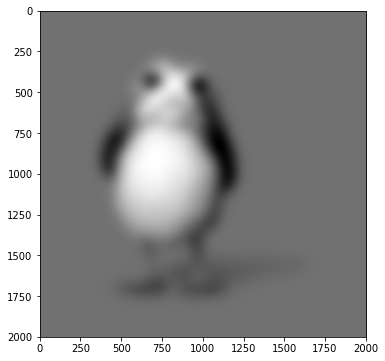

In [35]:
# Display the result of "blurring the porg"
plt.figure(figsize = [6, 6])
plt.imshow(img_ifft.real,cmap='gray');

Now let's do the same operation using the cuFFT library via pyculib. 

There are two ways of doing this, a single function to perform the FFT or a mechanism to create a 'plan' and then invoke this multiple times to perform forward and inverse transforms. This latter mechanism is intended to be familiar for users of the popular library [FFTW (Fastest Fourier Transform in the West)](http://www.fftw.org/).

In [36]:
import pyculib.fft as cufft

In [37]:
# At the time of writing pyculib doesn't seem to correctly deal with real to complex FFTs
# so we add an imaginary part to our data before passing to the GPU routines.
img_data_complex = img_data + 1j * np.zeros((dim,dim))
gauss2D_complex  = gauss2D  + 1j * np.zeros((dim,dim))

# Create new complex arrays to hold the output
img_fft   = np.empty((dim,dim),dtype=complex)
gauss_fft = np.empty((dim,dim),dtype=complex)
img_ifft  = np.empty((dim,dim),dtype=complex)

If we pass host numpy arrays into `cufft.fft()` then the input is automatically copied to the device before the transforms, and the output is copied back afterwards.

In [38]:
# We only need this if using the FFTW-like interface
#plan = cufft.FFTPlan((dim,dim),complex,complex)

t1 = timer()

# FFTW style
#plan.forward(img_data_complex,img_fft)
#plan.forward(gauss2D_complex,gauss_fft)

# Simple style
cufft.fft(img_data_complex,img_fft)
cufft.fft(gauss2D_complex,gauss_fft)

t2 = timer()

# Print time taken
print("Forward fast Fourier Transforms using cuFFT took : ",1000*(t2-t1)," milliseconds.")

Forward fast Fourier Transforms using cuFFT took :  148.24590494390577  milliseconds.


In [25]:
# Multiplication in Fourier space
img_conv = img_fft * gauss_fft

In [26]:
# Transform back into real space

t1 = timer()

# FFTW style
#plan.inverse(img_conv,img_ifft)

# Simple style
cufft.ifft(img_conv,img_ifft)

t2 = timer()

print("Inverse fast Fourier Transform using cuFFT took : ",1000*(t2-t1) ," milliseconds.")

Inverse fast Fourier Transform using cuFFT took :  5.174613907001913  milliseconds.


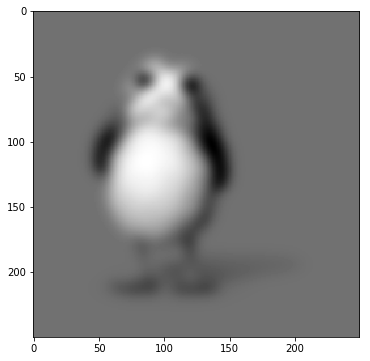

In [27]:
# Display the result of "blurring the porg" using the GPU
plt.figure(figsize = [6, 6])
plt.imshow(img_ifft.real,cmap='gray');

As with the matrix multiplication example we can seperate the data transfer from the actual Fourier transforms. This will allow us to measure the time taken to perform the transforms seperately from the memory transfer, and (in more involved codes) eliminate unnecessary copies between host and device.

In [28]:
# Copy input data arrays to the device 
d_img_data_complex = cuda.to_device(img_data_complex)
d_gauss2D_complex = cuda.to_device(gauss2D_complex)

# Create new device arrays to hold the output
d_img_fft = cuda.device_array((dim,dim),dtype=np.complex)
d_gauss_fft = cuda.device_array((dim,dim),dtype=np.complex)

# Start the timer
t1 = timer()

# Perform the forward FFTs
cufft.fft(d_img_data_complex,d_img_fft)
cufft.fft(d_gauss2D_complex,d_gauss_fft)
        
t2 = timer()

# Print time taken
print("Forward fast Fourier Transforms using cuFFT took : ",1000*(t2-t1)," milliseconds.")
    
# Copy the result back to the host
img_fft=d_img_fft.copy_to_host()
gauss_fft = d_gauss_fft.copy_to_host()

# Multiply each element in fft_img by the corresponding image in fft_gauss
img_conv = img_fft * gauss_fft

# Copy the product to the device
d_img_conv = cuda.to_device(img_conv)

# Create a new device array to hold the result of the FFT
d_img_ifft = cuda.device_array((dim,dim),dtype=np.complex)

t1 = timer()

# Perform the inverse FFT on the data
cufft.ifft(d_img_conv,d_img_ifft)

t2 = timer()

# Print time taken
print("Inverse fast Fourier Transform using cuFFT took : ",1000*(t2-t1)," milliseconds.")

# Copy result back to host
img_ifft = d_img_ifft.copy_to_host()

Forward fast Fourier Transforms using cuFFT took :  3.9832519832998514  milliseconds.
Inverse fast Fourier Transform using cuFFT took :  1.6005760990083218  milliseconds.


Wouldn't it be great if we could perform the multiplication at line 26 on the GPU? That way we'd never have to copy `img_fft` and `gauss_fft` back to the host, or copy `img_host` to the device. The entire convolution would be done on the GPU.

We'll do exactly that tomorrow when we learn about writing *kernels*.

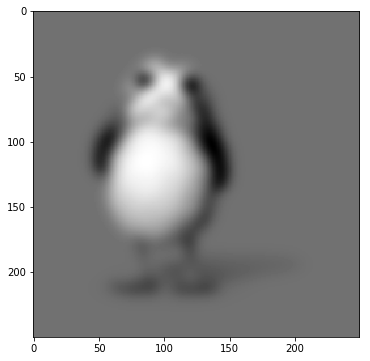

In [29]:
# Check that we still goet the correct result
plt.figure(figsize = [6, 6])
plt.imshow(img_ifft.real,cmap='gray');

## cuFFT exercises

As with the matrix exercises, you  now have everything you need to cannibalise the code snippets above and construct some python scripts which you can run outside of this notebook environment on the Tinis GPU node. As before, you should average over several runs to evaluate performance.

Things to investigate:

* How does the performance of cuFFT compare to numpy as a function of image size? Try using the full 2000x2000 pixel image without resizing.

* How much of the time taken by cuFFT is spent in memory transfers between host and device?

* (Advanced) Investigate the [Python interface to FFTW](https://github.com/pyFFTW/pyFFTW). How does this perform in comparison to numpy and cuFFT?  Does the GPU only appear fast here because the numpy FFT implementation is sub-optimal? You might need to install pyFFTW using `pip install --user pyfftw` inside the environment you launched the notebook from.

* (Advanced) As with the matrix example, how does performance change if using single precision arithmetic?

* (Very advanced) cuFFT provides the ability to perform multiple FFTs concurrently across multiple GPUs by providing multiple sets of input in batches. Can you GPU accelerate applying a Gaussian filter to the original *colour* image by constructing a batch of FFTS, one for each colour? You might need the [cuFFT documentaion](https://docs.nvidia.com/cuda/cufft/index.html) as well as that for the Python interface.



Tutors will be available during the session to help you answer these questions.


## Other libraries

Many other GPU accelerated libraries exist. For example...

* [cuRAND](http://pyculib.readthedocs.io/en/latest/curand.html)      : Part of the Nvidia toolkit. Fast random number generation on GPUs for applications which need large numbers of samples 
* [cuSPARSE](http://pyculib.readthedocs.io/en/latest/cusparse.html)    : Also part of the Nvidia toolkit. Sparse linear algebra library
* [cuDNN](https://developer.nvidia.com/cudnn)       : Nvidia Deep Neural Network Library (used by e.g. [TensorFlow](https://www.tensorflow.org/)) 
* [libgpuarray](http://deeplearning.net/software/libgpuarray/installation.html) : Another tensor manipulation library with [PyGPU](http://deeplearning.net/software/libgpuarray/pyapi/pygpu.html) as the Python interface. Used by [Theano](http://deeplearning.net/software/theano/) 

These are all available in the environment we loaded when following the instructions on the connecting page. Feel free to play around with them.